In [18]:
import fitsio
import numpy as np
import matplotlib.pyplot as plt
import json
from desitarget.targetmask import desi_mask
import glob
from collections import Counter
plt.rcParams.update({'font.size': 15})


In [75]:
program = "dark_gray"
program = "bright"
hemisphere = "north"
target_mask = desi_mask["BGS_ANY"]
targetdata = fitsio.read("targets/{}_{}.fits".format(program, hemisphere))
targetdata = np.sort(targetdata, order='TARGETID')

In [57]:
n = len(targetdata)
r = np.random.random(n)
rr = r < 0.001

In [58]:
fba_files = glob.glob("fba_{}_{}/fba-*.fits".format(program, hemisphere))
print(len(fba_files))

1851


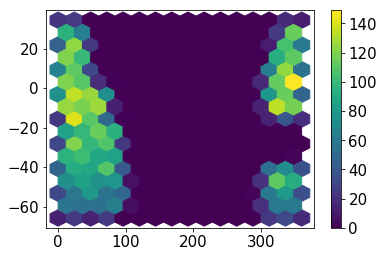

In [59]:
#plt.scatter(, , s=0.1)
plt.hexbin((targetdata['RA'][rr]), targetdata['DEC'][rr], gridsize=15,bins=None)
plt.colorbar()

In [60]:
targetid_assigned = np.empty((0), dtype=np.int64)
targetid_available = np.empty((0), dtype=np.int64)
for fba_file in fba_files[:100]:
    fassign = fitsio.read(fba_file, ext="FASSIGN")
    favail = fitsio.read(fba_file, ext="FAVAIL")
    targetid_assigned = np.append(targetid_assigned, fassign["TARGETID"])
    targetid_available = np.append(targetid_available, favail["TARGETID"])

In [61]:
targetid_assigned

array([ 35186134183054886,  35186134183054710, 611646886486474972, ...,
       611646756047814657, 611646750091903267, 611646750091903253])

In [62]:
counter_assigned = Counter(targetid_assigned)

In [63]:
set(counter_assigned.values())

{1, 2, 3}

In [71]:
is_available = np.zeros(len(targetdata), dtype=int)
is_assigned = np.zeros(len(targetdata), dtype=int)

In [72]:
id_available = np.in1d(targetdata['TARGETID'], targetid_available)
is_available[id_available] = 1

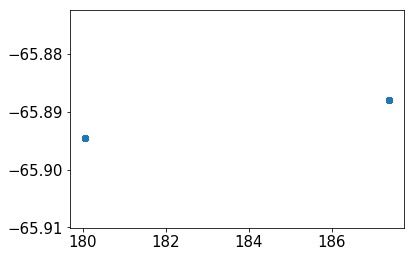

In [74]:
plt.scatter((targetdata['RA'][is_available]-180)%360, targetdata['DEC'][is_available])